In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
%matplotlib inline
np.random.seed(1)

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # Train Set Features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) # Train Set Labels
    
    test_dataset = h5py.File('datasets/test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # Test Set Features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # Test Set Labels
    
    classes = np.array(test_dataset['list_classes'][:]) # List of Classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
y_hat = tf.constant(36, name='y_hat') # Define y_hat constant
y = tf.constant(29, name='y') # Define y constant

loss = tf.Variable((y-y_hat)**2, name='loss') # Create a Variable for the loss

print(loss.numpy())

49


In [5]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    Y = WX + b 
    """
    np.random.seed(1)
    
    X = np.random.randn(3, 1)
    W = np.random.randn(4, 3)
    b = np.random.randn(4, 1)
    Y = tf.add(tf.matmul(W, X), b)
    
    return Y

In [6]:
print("Result = \n" + str(linear_function().numpy()))

Result = 
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


In [7]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    z = tf.constant(np.array(z), dtype=tf.float32)
    # compute sigmoid(x)
    sigmoid = tf.sigmoid(z)
    
    return sigmoid.numpy()

In [8]:
sigmoid(5)

0.9933072

In [9]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999938


In [10]:
def cost(logits, labels):
    logits = tf.constant(logits, dtype=tf.float32)
    labels = tf.constant(labels, dtype=tf.float32)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits, labels)
    return cost.numpy()

In [11]:
logits = np.array([0.2,0.4,0.7,0.9])

cost = cost(logits, np.array([0,0,1,1]))
print ("cost = " + str(cost))

cost = [0.6931472 0.6931472 0.6132617 0.4132617]


In [12]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')
                    
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
                    
    return one_hot_matrix.numpy()

In [13]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
print ("one_hot = \n" + str(one_hot))

one_hot = 
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [14]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    
    # Create "ones" tensor using tf.ones(...)
    ones = tf.ones(shape)
    
    return ones.numpy()

In [15]:
print ("ones = " + str(ones([3])))

ones = [1. 1. 1.]


# 2 - Building your first neural network in tensorflow

In this part of the assignment you will build a neural network using tensorflow. Remember that there are two parts to implement a tensorflow model:

- Create the computation graph
- Run the graph

Let's delve into the problem you'd like to solve!

### 2.0 - Problem statement: SIGNS Dataset

One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [16]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

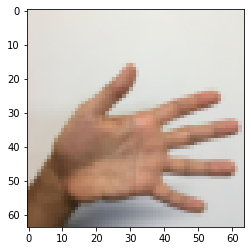

In [17]:
index = 0
plt.imshow(X_train_orig[index])

In [18]:
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

y = 5


In [19]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [20]:
# Flatten the training and test images
X_train_Flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_Flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize Image Vectors
X_train = X_train_Flatten / 255.0
X_test = X_test_Flatten / 255.0

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [28]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    tf.random.set_seed(1)
    # Glorot Uniform Initializer is same as Xavier Initializer
    initializer = tf.initializers.GlorotUniform()
    zeroInit = tf.zeros_initializer()
    
    W1 = tf.Variable(initializer(shape=(25,12288)), name="W1")
    b1 = tf.Variable(zeroInit(shape=(25,1)), name="b1")
    W2 = tf.Variable(initializer(shape=(12,25)), name="W2")
    b2 = tf.Variable(zeroInit(shape=(12,1)), name="b2")
    W3 = tf.Variable(initializer(shape=(6,12)), name="W3")
    b3 = tf.Variable(zeroInit(shape=(6,1)), name="b3")
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [29]:
parameters = initialize_parameters()
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32, numpy=
array([[-1.47842336e-02,  1.77251101e-02,  5.78241609e-03, ...,
        -5.74509054e-03,  1.67791806e-02, -1.76099837e-02],
       [ 7.10822642e-05,  4.51281667e-04, -1.82342455e-02, ...,
         1.36572979e-02, -1.17452955e-02,  1.81304589e-02],
       [-1.38530191e-02, -8.04699305e-03, -5.75006939e-03, ...,
        -1.64859798e-02, -1.49659812e-03, -1.96594968e-02],
       ...,
       [ 1.79477036e-02, -1.62059460e-02,  1.37278400e-02, ...,
         1.88305639e-02, -4.04859334e-03,  8.19192454e-03],
       [ 3.84624675e-03, -1.64127555e-02, -1.21785151e-02, ...,
         1.00171529e-02,  4.27778065e-03,  5.20760752e-03],
       [-4.29783016e-04,  1.21666379e-02, -1.83665771e-02, ...,
        -2.16038935e-02,  1.55930333e-02, -1.61311366e-02]], dtype=float32)>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.

In [30]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [31]:
X, Y = 12288, 6
parameters = initialize_parameters()
Z3 = forward_propagation(X, parameters)
print("Z3 = " +str(Z3))

InvalidArgumentError: cannot compute _MklMatMul as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:MatMul] name: MatMul/